<img src="https://raw.githubusercontent.com/NCAR/dask-tutorial/main/images/NCAR-contemp-logo-blue.png"
     width="750px"
     alt="NCAR logo"
     style="vertical-align:middle;margin:30px 0px"/>

# Dask DataFrame


**ESDS dask tutorial | 06 February, 2023**  

Negin Sobhani, Brian Vanderwende, Deepak Cherian, Ben Kirk  
Computational & Information Systems Lab (CISL)  
[negins@ucar.edu](mailto:negins@ucar.edu), [vanderwb@ucar.edu](mailto:vanderwb@ucar.edu)

---------
### In this tutorial, you learn:

* Basic concepts and features of Dask Dataframes
* Applications of Dask DataFrames
* Interacting with Dask DataFrames
* Built-in operations with Dask DataFrames
* Dask DataFrames Best Practices

### Related Documentation

* [DataFrame documentation](https://docs.dask.org/en/latest/dataframe.html)
* [DataFrame API](https://docs.dask.org/en/latest/dataframe-api.html)
* [DataFrame examples](https://examples.dask.org/dataframe.html)
* [pandas documentation](https://pandas.pydata.org/pandas-docs/stable/)


---------

## Dask DataFrame 

pandas is a very popular tool for working with tabular datasets, but the dataset needs to fit into the memory. 

pandas operates best with smaller datasets, and if you have a large dataset, you’ll receive an out of memory error using pandas. A general rule of thumb for pandas is:

> "Have 5 to 10 times as much RAM as the size of your dataset"
>
> ~ Wes McKinney (2017) in [10 things I hate about pandas](https://wesmckinney.com/blog/apache-arrow-pandas-internals/)




Dask dataframe can be used to solve pandas performance issues and with larger-than-memory datasets.

<img src="../images/dask_dataframe.png"
     align="right"
     width="50%"
     alt="Dask DataFrame is composed of pandas DataFrames"/>

**A Dask DataFrame is a parallel DataFrame composed of smaller pandas DataFrames (also known as partitions).**

Dask dataframes looks and feels like the pandas DataFrames on the surface, but enable parallel and distributed workflow.

One operation on a Dask DataFrame triggers several operations on the constituent pandas DataFrames.These pandas dataframes may live on disk or on different machines in a cluster. 

**Similar to Dask Arrays, Dask DataFrames are lazy!**  

Unlike pandas, operations on Dask DataFrames are not computed until you explicitly request them (e.g. by calling `.compute`).


## When to use or not use Dask DataFrame?

Dask DataFrame is used in situations where pandas fails or has poor performance due to data size.  

**However, if your datset fit well into memory, then you may be better off not using Dask DataFrames.**

Dask DataFrame is a good choice when doing **parallalizeable computations**.  
Some examples are:
* Element-wise operations such as `df.x + df.y`
* Row-wise filtering such as `df[df.x>0]`
* Common aggregations such as `df.x.max()`
* Dropping duplicates such as `df.x.drop_duplicate()`

However, Dask is not great for operations that requires shuffling or re-indexing.  
Some examples are:
* Set index: `df.set_index(df.x)`
* Some operations like groupby-apply on unsorted columns: `df.groupby(df.x).apply(myfunc)`


 
<div class="alert alert-block alert-warning">

<b>WARNING:</b> Although, Dask DataFrame has a very similar interface to the pandas DataFrame (as we will see in this tutorial), it does NOT include some of the pandas interface yet. See the [Dask DataFrame API documentation](https://docs.dask.org/en/stable/dataframe-api.html) for a compehnsive list of available functions. 

</div>


--------------------

## Tutorial Dataset
In this tutorial, we are going to use NOAA Global Historical Climatology Network Daily (GHCN-D) dataset.  
GHCN-D is a public available dataset that includes daily climate records from +100,000 surface observations around the world.  
This is an example of a real dataset that is used by NCAR scientists for their research. GHCN-D raw dataset for all stations is available through [NOAA Climate Data Online](https://www.ncdc.noaa.gov/cdo-web/search?datasetid=GHCND). 

**To learn more about GHCNd dataset, please visit:**
* [GHCNd Journal Paper](https://journals.ametsoc.org/view/journals/atot/29/7/jtech-d-11-00103_1.xml)
* [GHCNd Official Website](https://www.ncei.noaa.gov/products/land-based-station/global-historical-climatology-network-daily)

### Download the data:
For this example, we are going to look through a subset of data from GHCN-D dataset.

First, we look at the daily observations from Denver International Airport, next we are going to look through more stations in Colorado. 

The access dataset for this tutorial, please run the following script:

In [1]:
pwd

'/glade/work/negins/dask/dask-tutorial/notebooks'

In [2]:
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1cKKGhuH6yJ0I8_mqu4M9viBAT5vkCOEo' -O ../data.tar.gz
!tar -xvf ../data.tar.gz -C ..

--2023-01-29 21:21:53--  https://docs.google.com/uc?export=download&id=1cKKGhuH6yJ0I8_mqu4M9viBAT5vkCOEo
Resolving docs.google.com... 142.250.72.78, 2607:f8b0:400f:807::200e
Connecting to docs.google.com|142.250.72.78|:443... connected.
HTTP request sent, awaiting response... 416 Requested range not satisfiable

    The file is already fully retrieved; nothing to do.

data/
data/USC00051528.csv
data/USC00053951.csv
data/USW00003017.csv
data/USC00050848.csv
data/USC00059243.csv
data/USC00051564.csv
data/USC00052446.csv
data/USC00057167.csv
data/USC00053146.csv
data/USC00051741.csv
data/USC00054770.csv
data/USC00055722.csv
data/USC00058429.csv
data/USC00053662.csv
data/USC00058204.csv
data/USC00055322.csv
data/USC00052281.csv
data/USC00054076.csv
data/USC00054834.csv
data/USC00053038.csv
data/USC00053005.csv
data/USC00057936.csv
data/USC00057337.csv
data/USC00052184.csv
data/USC00051294.csv


This script should save the preprocessed GHCN-D data in `../data` path.


-----------
### Let's start with an example using pandas DataFrame:


First, let's read in the comma-seperated GHCN-D dataset for one station at **Denver International Airpot (DIA), CO** (site ID : `USW00003017`).

To see the list of all available GHCN-D sites and their coordinates and IDs, please see [this link](https://www.ncei.noaa.gov/pub/data/ghcn/daily/ghcnd-stations.txt).

In [2]:
import os
import pandas as pd

# DIA ghcnd id
site = 'USW00003017'
data_dir = '../data'


df = pd.read_csv(os.path.join(data_dir, site+'.csv'), parse_dates=['DATE'], index_col=0)


In [3]:
# Display the top five rows of the dataframe
df.head()

,ID,YEAR,MONTH,DAY,TMAX,TMAX_FLAGS,TMIN,TMIN_FLAGS,PRCP,PRCP_FLAGS,...,RHMN_FLAGS,RHMX,RHMX_FLAGS,PSUN,PSUN_FLAGS,LATITUDE,LONGITUDE,ELEVATION,STATE,STATION
DATE,,,,,,,,,,,,,,,,,,,,,
1994-07-20,USW00003017,1994,7,20,316.0,XXS,150.0,XXS,20.0,DXS,...,XXX,NaN,XXX,NaN,XXX,39.8467,-104.6561,1647.1,CO,DENVER INTL AP
1994-07-23,USW00003017,1994,7,23,355.0,XXS,166.0,XXS,0.0,DXS,...,XXX,NaN,XXX,NaN,XXX,39.8467,-104.6561,1647.1,CO,DENVER INTL AP
1994-07-24,USW00003017,1994,7,24,333.0,XXS,155.0,XXS,81.0,DXS,...,XXX,NaN,XXX,NaN,XXX,39.8467,-104.6561,1647.1,CO,DENVER INTL AP
1994-07-25,USW00003017,1994,7,25,327.0,XXS,172.0,XXS,0.0,DXS,...,XXX,NaN,XXX,NaN,XXX,39.8467,-104.6561,1647.1,CO,DENVER INTL AP
1994-07-26,USW00003017,1994,7,26,327.0,XXS,155.0,XXS,0.0,DXS,...,XXX,NaN,XXX,NaN,XXX,39.8467,-104.6561,1647.1,CO,DENVER INTL AP


What variables are available?

To see the description of the dataset, variables, and units, please see [this link](https://www.ncei.noaa.gov/pub/data/ghcn/daily/readme.txt).

In [4]:
# How many days worth of data do we have at this station?
len(df)

9941

### Operations on pandas DataFrame

#### Simple Analysis
pandas DataFrames has several features that give us flexibility to do different calculations and analysis on our dataset.

For example: 
* When was the coldest day at this station during December of last year?

In [5]:
# use python slicing notation inside .loc 
# use idxmin() to find the index of minimum valus
df.loc['2022-12-01':'2022-12-31'].TMIN.idxmin()

Timestamp('2022-12-22 00:00:00')

<AxesSubplot: xlabel='DATE'>

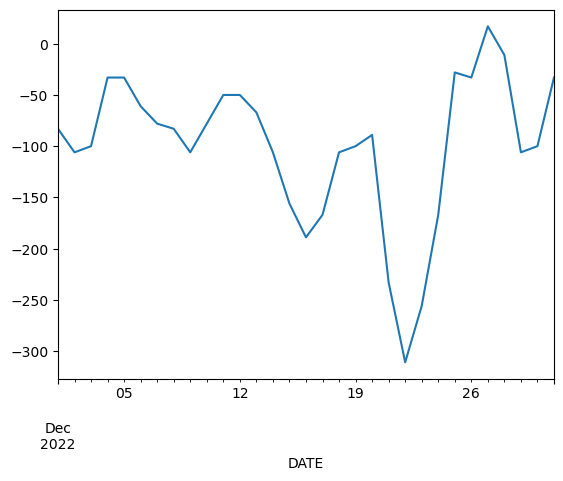

In [6]:
# Here we easily plot the prior data using matplotlib from pandas
df.loc['2022-12-01':'2022-12-31'].TMIN.plot()

* How many snow days do we have each year at this station?

In [7]:
# Create a "groupby object" based on the selected columns
# which can return info like the count or size of each type of the column value
# we count days where SNOW>0, and sort them and show top 5 years:
df[df['SNOW']>0].groupby('YEAR').size().sort_values(ascending=False).head()

YEAR
2015    36
2019    34
2014    32
2008    32
2007    31
dtype: int64

Or more complex analyasis:

For example, we have head that this could be Denver's first January in 13 years with no 60-degree days.  


<img src="../images/denver.png"
     align="right"
     alt="Dask DataFrame is composed of pandas DataFrames"/>

Below, we show all days with high temperature above 60 F since 2010:

In [8]:
df[(df['MONTH']==1) & (df['YEAR']>2010) & (df['TMAX']>155.5)].groupby(['YEAR'])['TMAX'].size()

YEAR
2011    1
2012    6
2013    4
2014    3
2015    6
2016    1
2017    4
2018    5
2019    3
2020    2
2021    2
2022    3
Name: TMAX, dtype: int64

How big is this dataset for one station?

First, let's check the file size:

In [9]:
!ls -lh /glade/work/negins/dask/get-station-data/get_noaa_ghcn_data/output/USW00003017.csv

-rw-r--r-- 1 negins ncar 3.6M Jan 29 22:07 /glade/work/negins/dask/get-station-data/get_noaa_ghcn_data/output/USW00003017.csv


Similar to the previous tutorial, we can use the following function to find the size of a variable on memory.

In [10]:
# Define function to display variable size in MB
def var_size(in_var):
    result = sys.getsizeof(in_var) / 1e6
    print(f"Size of variable: {result:.2f} MB")

In [11]:
var_size(df)

Size of variable: 33.21 MB


pandas dataframe `.info` method also shows memory usage of a panda dataframe at the end of its report:


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9941 entries, 1994-07-20 to 2023-01-20
Data columns (total 99 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   ID          9941 non-null   object 
 1   YEAR        9941 non-null   int64  
 2   MONTH       9941 non-null   int64  
 3   DAY         9941 non-null   int64  
 4   TMAX        9941 non-null   float64
 5   TMAX_FLAGS  9941 non-null   object 
 6   TMIN        9941 non-null   float64
 7   TMIN_FLAGS  9941 non-null   object 
 8   PRCP        9938 non-null   float64
 9   PRCP_FLAGS  9941 non-null   object 
 10  TAVG        5918 non-null   float64
 11  TAVG_FLAGS  9941 non-null   object 
 12  SNOW        6207 non-null   float64
 13  SNOW_FLAGS  9941 non-null   object 
 14  SNWD        6352 non-null   float64
 15  SNWD_FLAGS  9941 non-null   object 
 16  AWND        9914 non-null   float64
 17  AWND_FLAGS  9941 non-null   object 
 18  FMTM        6114 non-null   float64
 19  FMTM_FLAG

**Why is there a different between the `.info` method and `sys.getsizeof`?**

To get the full memory usage, we need to provide `memory_usage=”deep”` argument to info(). By passing memory_usage="deep", we are ensuring more accurate memory usage report, accounting for the full usage of the contained objects. 

In [13]:
# deep option will include memory used by mutable objects
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9941 entries, 1994-07-20 to 2023-01-20
Data columns (total 99 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   ID          9941 non-null   object 
 1   YEAR        9941 non-null   int64  
 2   MONTH       9941 non-null   int64  
 3   DAY         9941 non-null   int64  
 4   TMAX        9941 non-null   float64
 5   TMAX_FLAGS  9941 non-null   object 
 6   TMIN        9941 non-null   float64
 7   TMIN_FLAGS  9941 non-null   object 
 8   PRCP        9938 non-null   float64
 9   PRCP_FLAGS  9941 non-null   object 
 10  TAVG        5918 non-null   float64
 11  TAVG_FLAGS  9941 non-null   object 
 12  SNOW        6207 non-null   float64
 13  SNOW_FLAGS  9941 non-null   object 
 14  SNWD        6352 non-null   float64
 15  SNWD_FLAGS  9941 non-null   object 
 16  AWND        9914 non-null   float64
 17  AWND_FLAGS  9941 non-null   object 
 18  FMTM        6114 non-null   float64
 19  FMTM_FLAG

Remember, the above rule?

> "Have 5 to 10 times as much RAM as the size of your dataset"
>
> ~ Wes McKinney (2017) in [10 things I hate about pandas](https://wesmckinney.com/blog/apache-arrow-pandas-internals/)



----------------------------------------------------------------

So far, we read in and analyzed data for one station. We have a total of +118,000 stations over the world and +4500 stations in Colorado alone! 

What if we want to look at the larger dataset? 

## Scaling up to larger dataset

Let's start by reading data from selected stations in the state of Colorado. The downloaded data for this example includes the climatology observations from 25 selected sites in Colorado.

Pandas can concatenate data to load data spread across multiple files:


In [14]:
!du -ach ../data/*.csv

8.8M	../data/USC00050848.csv
8.8M	../data/USC00051294.csv
8.4M	../data/USC00051528.csv
8.6M	../data/USC00051564.csv
6.5M	../data/USC00051741.csv
7.7M	../data/USC00052184.csv
7.1M	../data/USC00052281.csv
7.5M	../data/USC00052446.csv
12M	../data/USC00053005.csv
8.2M	../data/USC00053038.csv
8.3M	../data/USC00053146.csv
7.8M	../data/USC00053662.csv
7.0M	../data/USC00053951.csv
8.2M	../data/USC00054076.csv
8.4M	../data/USC00054770.csv
8.8M	../data/USC00054834.csv
7.3M	../data/USC00055322.csv
8.3M	../data/USC00055722.csv
8.9M	../data/USC00057167.csv
7.3M	../data/USC00057337.csv
8.0M	../data/USC00057936.csv
7.7M	../data/USC00058204.csv
7.9M	../data/USC00058429.csv
8.1M	../data/USC00059243.csv
3.6M	../data/USW00003017.csv
198M	total


In [147]:
%%time
import glob
co_sites = glob.glob(os.path.join(data_dir, '*.csv'))
df = pd.concat(pd.read_csv(f, index_col=0, parse_dates=['DATE']) for f in co_sites)

CPU times: user 4.41 s, sys: 496 ms, total: 4.9 s
Wall time: 6.72 s


* How many stations have we read in?

In [16]:
print ("Concatenated data for", len(df.ID.unique()), "unique GHCND sites.")

Concatenated data for 25 unique GHCND sites.


* Who many years worth of data do we have?

In [17]:
len(df['YEAR'].unique())

131

Now that we concatenated the data for all sites in one DataFrame, we can do similar analysis on it:

* When was the coldest date ever recorded at these Colorado sites?

In [86]:
print ('Coldest day ever recorded at these sites in Colorado : ', df['TMIN'].idxmin())

Coldest day ever recorded at these sites in Colorado :  2019-07-01 00:00:00


* Which Colorado site has recorded the most snow days in a year?

In [87]:
%%time

snowy_days = df[df['SNOW']>0].groupby(['ID','YEAR']).size()

print ('This CO site has the highest number of snow days in a year : ')

print ('Site',snowy_days.idxmax()[0], 
       'in',snowy_days.idxmax()[1],':', snowy_days.max(),' snow days')

snowy_days.agg(['idxmax','max'])

This CO site has the highest number of snow days in a year : 
Site USC00052281 in 1983 : 102  snow days
CPU times: user 86.3 ms, sys: 3.65 ms, total: 89.9 ms
Wall time: 96.6 ms


idxmax    (USC00052281, 1983)
max                       102
dtype: object

In [100]:
df

,ID,YEAR,MONTH,DAY,PRCP,PRCP_FLAGS,TMAX,TMAX_FLAGS,TMIN,TMIN_FLAGS,...,DAWM,DAWM_FLAGS,MDWM,MDWM_FLAGS,WDFG,WDFG_FLAGS,WSFG,WSFG_FLAGS,WESF,WESF_FLAGS
DATE,,,,,,,,,,,,,,,,,,,,,
1902-08-01,USC00051528,1902,8,1,0.0,PX6,NaN,XXX,NaN,XXX,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1902-08-02,USC00051528,1902,8,2,0.0,PX6,NaN,XXX,NaN,XXX,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1902-08-03,USC00051528,1902,8,3,0.0,PX6,NaN,XXX,NaN,XXX,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1902-08-04,USC00051528,1902,8,4,0.0,PX6,NaN,XXX,NaN,XXX,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1902-08-05,USC00051528,1902,8,5,0.0,PX6,NaN,XXX,NaN,XXX,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-01-21,USC00051294,2023,1,21,0.0,XXH,11.0,XXH,-94.0,XXH,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-22,USC00051294,2023,1,22,0.0,XXH,28.0,XXH,-111.0,XXH,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-23,USC00051294,2023,1,23,0.0,XXH,56.0,XXH,-83.0,XXH,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


* What was the average monthly temperature of snow days every year?

In [115]:
%%time
df[(df['SNOW']>0)].groupby(['ID','YEAR','MONTH'])['TMAX'].mean()

CPU times: user 86.7 ms, sys: 1.28 ms, total: 88 ms
Wall time: 127 ms


ID           YEAR  MONTH
USC00050848  1893  11       28.0
                   12       39.0
             1894  1       -27.5
                   2        -4.0
                   3        63.0
                            ... 
USW00003017  2022  3        19.0
                   5        75.0
                   11        3.6
                   12       -8.6
             2023  1         2.4
Name: TMAX, Length: 15285, dtype: float64

**Excersise:** Which Colorado site has recorded the most snow days in 2023?

Let's calculate average temperature based on TMIN and TMAX at each site:

In [116]:
df.columns

Index(['ID', 'YEAR', 'MONTH', 'DAY', 'PRCP', 'PRCP_FLAGS', 'TMAX',
       'TMAX_FLAGS', 'TMIN', 'TMIN_FLAGS',
       ...
       'DAWM', 'DAWM_FLAGS', 'MDWM', 'MDWM_FLAGS', 'WDFG', 'WDFG_FLAGS',
       'WSFG', 'WSFG_FLAGS', 'WESF', 'WESF_FLAGS'],
      dtype='object', length=131)

------------------
Now, let's look at the size of the dataset on memory:

In [118]:
%%time
var_size(df)

Size of variable: 3368.64 MB
CPU times: user 4.19 s, sys: 11 ms, total: 4.2 s
Wall time: 4.94 s


**Dask allows us to conceptualize all of these files as a single dataframe!**

In [119]:
# Let's do a little cleanup (Python will not return the memory to the OS, however)
#del df, snowy_days

## Computations on Dask DataFrame

### Create a "LocalCluster" Client with Dask

In [131]:
from dask.distributed import Client, LocalCluster

cluster = LocalCluster()
client = Client(cluster)
client

/glade/u/apps/opt/conda/envs/npl-2023a/lib/python3.9/site-packages/distributed/node.py:183: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 38366 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/negins/workforce/proxy/38366/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/negins/workforce/proxy/38366/status,Workers: 1
Total threads: 1,Total memory: 32.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:46663,Workers: 1
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/negins/workforce/proxy/38366/status,Total threads: 1
Started: Just now,Total memory: 32.00 GiB
Comm: tcp://127.0.0.1:42489,Total threads: 1
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/negins/workforce/proxy/42772/status,Memory: 32.00 GiB
Nanny: tcp://127.0.0.1:43937,


### Dask DataFrame `read_csv` to read multiple files

`dask.dataframe.read_csv` function can be used in conjunction with `glob` to read multiple csv files at the same time. 

Remember we can read one file with `pandas.read_csv`. For reading multiple files with pandas, we have to concatenate them with `pd.concatenate`. However, we can read many files at once just using `dask.dataframe.read_csv`.

Overall, Dask is designed to perform I/O in parallel and is more performant than pandas for operations with multiple files or large files.

In [148]:
%%time
import dask.dataframe as dd

ddf = dd.read_csv(co_sites, parse_dates=['DATE'])
ddf

CPU times: user 11 ms, sys: 2 ms, total: 13 ms
Wall time: 14.3 ms


,DATE,ID,YEAR,MONTH,DAY,PRCP,PRCP_FLAGS,TMAX,TMAX_FLAGS,TMIN,TMIN_FLAGS,TOBS,TOBS_FLAGS,SNOW,SNOW_FLAGS,SNWD,SNWD_FLAGS,WT18,WT18_FLAGS,WT16,WT16_FLAGS,WT08,WT08_FLAGS,WT11,WT11_FLAGS,WT03,WT03_FLAGS,WT04,WT04_FLAGS,WT14,WT14_FLAGS,WT01,WT01_FLAGS,WT09,WT09_FLAGS,WT07,WT07_FLAGS,WT05,WT05_FLAGS,DASF,DASF_FLAGS,MDSF,MDSF_FLAGS,DAPR,DAPR_FLAGS,MDPR,MDPR_FLAGS,WT06,WT06_FLAGS,LATITUDE,LONGITUDE,ELEVATION,STATE,STATION
npartitions=25,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
,datetime64[ns],object,int64,int64,int64,float64,object,float64,object,float64,object,float64,object,float64,object,float64,object,float64,object,float64,object,float64,object,float64,object,float64,object,float64,object,float64,object,float64,object,float64,object,float64,object,float64,object,float64,object,float64,object,float64,object,float64,object,float64,object,float64,float64,float64,object,object
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [149]:
ddf.TMAX.mean()

dd.Scalar<series-..., dtype=float64>

**Notice that the representation of the DataFrame object contains no data just headers and datatypes.  Why?**

#### Lazy Evaluation

Similar to Dask Arrays, Dask DataFrames are lazy. Here the data has not yet been read into the dataframe yet (a.k.a. lazy evaluation).  
Dask just construct the task graph of the computation but it will "evaluate" them only when necessary.

**So how does Dask know the name and dtype of each column?**

Dask has just read the start of the first file and infer the column names and dtypes. 

Unlike `pandas.read_csv` that reads in all files before inferring data types, `dask.dataframe.read_csv` only reads in a sample from the beginning of the file (or first file if using a glob). The column names and dtypes are then enforced when reading the specific partitions.

Let's take a look at the start of our dataframe:

In [150]:
ddf.head()

,DATE,ID,YEAR,MONTH,DAY,PRCP,PRCP_FLAGS,TMAX,TMAX_FLAGS,TMIN,...,DAPR_FLAGS,MDPR,MDPR_FLAGS,WT06,WT06_FLAGS,LATITUDE,LONGITUDE,ELEVATION,STATE,STATION
0,1902-08-01,USC00051528,1902,8,1,0.0,PX6,NaN,XXX,NaN,...,XXX,NaN,XXX,NaN,XXX,39.2203,-105.2783,2097.0,CO,CHEESMAN
1,1902-08-02,USC00051528,1902,8,2,0.0,PX6,NaN,XXX,NaN,...,XXX,NaN,XXX,NaN,XXX,39.2203,-105.2783,2097.0,CO,CHEESMAN
2,1902-08-03,USC00051528,1902,8,3,0.0,PX6,NaN,XXX,NaN,...,XXX,NaN,XXX,NaN,XXX,39.2203,-105.2783,2097.0,CO,CHEESMAN
3,1902-08-04,USC00051528,1902,8,4,0.0,PX6,NaN,XXX,NaN,...,XXX,NaN,XXX,NaN,XXX,39.2203,-105.2783,2097.0,CO,CHEESMAN
4,1902-08-05,USC00051528,1902,8,5,0.0,PX6,NaN,XXX,NaN,...,XXX,NaN,XXX,NaN,XXX,39.2203,-105.2783,2097.0,CO,CHEESMAN


In [151]:
%%time

snowy_days =ddf.groupby(['YEAR']).size()
snowy_days.compute()

CPU times: user 367 ms, sys: 71.1 ms, total: 438 ms
Wall time: 7.01 s


YEAR
1902    5277
1903    5735
1904    6108
1905    5802
1906    6265
        ... 
1898    5005
1899    4205
1900    4800
1901    5319
1896    4164
Length: 131, dtype: int64

<div class="alert alert-block alert-info" markdown="1">

<b>NOTE:</b>  Whenever we operate on our dataframe we read through all of our CSV data so that we don’t fill up RAM. Dask will delete intermediate results (like the full pandas DataFrame for each file) as soon as possible. This enables you to handle larger than memory datasets but, repeated computations will have to load all of the data in each time.

</div>

Similar data manipulations as `pandas.dataframe` can be done for `dask.dataframes`.  
For example, let's find the highest number of snow days in Colorado:

In [152]:
%%time
snowy_days = ddf[ddf['SNOW']>0].groupby(['ID','YEAR']).size()
snowy_days.compute().agg(['idxmax','max'])

CPU times: user 378 ms, sys: 76.5 ms, total: 455 ms
Wall time: 7.24 s


idxmax    (USC00052281, 1983)
max                       102
dtype: object

#### Nice, but what did Dask do?

In [153]:
# Requires ipywidgets

snowy_days.dask

HighLevelGraph with 6 layers.
<dask.highlevelgraph.HighLevelGraph object at 0x2ac09f373b50>
 0. read-csv-e6b22b5e10f74397413ac72a822c6ef1
 1. getitem-ca4b46505a16cbdf39e1945ef86af8ee
 2. gt-f2da36092ce732f5e9436b011af32071
 3. getitem-e9e31e5900609ad052bd7d24475f0d06
 4. dataframe-groupby-size-chunk-04b0f8dbc169424be95bf93b02496d2e-ffba9fe8d04fc8b92fce58f1a2857d85
 5. dataframe-groupby-size-agg-04b0f8dbc169424be95bf93b02496d2e

You can also view the underlying task graph using `.visualize()`:

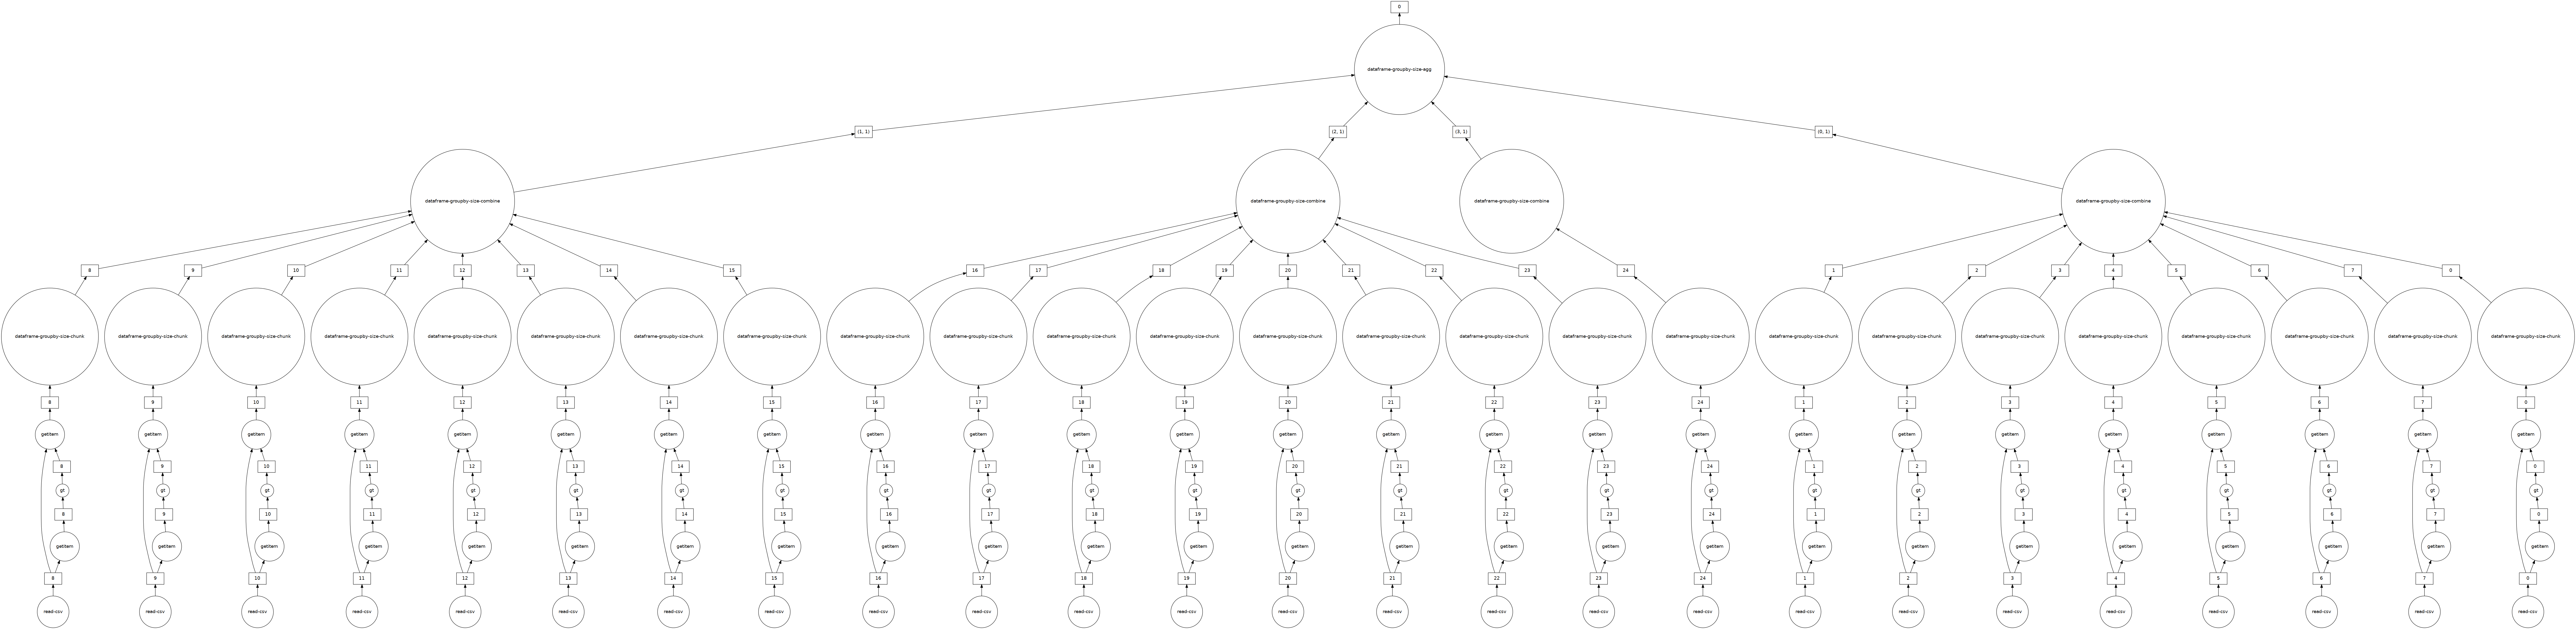

In [154]:
snowy_days.visualize()

### Use `.compute` wisely!

For most operations, `dask.dataframe` hashes the arguments, allowing duplicate computations to be shared, and only computed once.

For example, let's compute the mean and median for Maximum daily temperature of snow days.

In [200]:
snowy_days = ddf[ddf['SNOW']>0].groupby(['ID','YEAR'])
mean_tmax = snowy_days.TMAX.mean()
med_tmax = snowy_days.TMAX.median()

In [201]:
%%time

mean_tmax_result = mean_tmax.compute()
med_tmax_result = med_tmax.compute()

CPU times: user 780 ms, sys: 151 ms, total: 931 ms
Wall time: 15 s


But if we pass both arguments in a single `.compute`, we can share the intermediate results:

In [171]:
import dask

In [169]:
%%time
mean_tmax_result, med_tmax_result = dask.compute(mean_tmax, med_tmax)

CPU times: user 423 ms, sys: 97.2 ms, total: 520 ms
Wall time: 7.69 s


Here using `dask.compute` only one allowed sharing intermediate results between TMAX mean and median calculations and improved total performance. 

In [174]:
mean_tmax.dask

HighLevelGraph with 9 layers.
<dask.highlevelgraph.HighLevelGraph object at 0x2ac0f1384160>
 0. read-csv-e6b22b5e10f74397413ac72a822c6ef1
 1. getitem-ca4b46505a16cbdf39e1945ef86af8ee
 2. gt-f2da36092ce732f5e9436b011af32071
 3. getitem-e9e31e5900609ad052bd7d24475f0d06
 4. series-groupby-count-chunk-5b4df03ea9e7aef99a8a280c3d6e88a1-8c64167d327100c1f599198d621386f0
 5. series-groupby-count-agg-5b4df03ea9e7aef99a8a280c3d6e88a1
 6. series-groupby-sum-chunk-225a56655d2b4605f41b132bcfef3b10-8992c52eb36e90b95b085d80a0f0f3be
 7. series-groupby-sum-agg-225a56655d2b4605f41b132bcfef3b10
 8. truediv-085d22bc2fd3f64dcd5e5ab128ad0873

Here some operations such as the calls to read the csv files, the filtering, and the grouping is exactly similar between both operations, so they can share intermediate results. Remember, Dask will delete intermediate results (like the full pandas DataFrame for each file) as soon as possible. 

### `.persist` or caching
Sometimes you might want your computers to keep intermediate results in memory, if it fits the memory. 

The `.persist()` method can be used to  “cache” data and tell dask what results to keep around. You should only use `.persist()` with any data or computation that fits in memory.

For example, if we want to only do analysis on a subset of data (for example snow days at Boulder site):

In [188]:
boulder_snow = ddf[(ddf['SNOW']>0)&(ddf['ID']=='USC00050848')]

In [195]:
%%time
tmax = boulder_snow.TMAX.mean().compute()
tmin = boulder_snow.TMIN.mean().compute()

print (tmin, tmax)

-74.72270037654653 37.49704618689581
CPU times: user 943 ms, sys: 193 ms, total: 1.14 s
Wall time: 16.1 s


In [196]:
boulder_snow = ddf[(ddf['SNOW']>0)&(ddf['ID']=='USC00050848')].persist()

In [198]:
%%time

tmax = boulder_snow.TMAX.mean().compute()
tmin = boulder_snow.TMIN.mean().compute()
print (tmin, tmax)

-74.72270037654653 37.49704618689581
CPU times: user 76.3 ms, sys: 4.72 ms, total: 81 ms
Wall time: 251 ms


As you can see the analysis on this persisted data is much faster because we are not repeating the loading and selecting.

## Dask DataFrames Best Practices

### Use pandas (when you can)
For data that fits into RAM, pandas can often be easier and more efficient to use than Dask DataFrame. However, Dask DataFrame is a powerful tool for larger-than-memory datasets. 

When the data is still larger than memory, Dask DataFrame can be used to **reduce** the larger datasets to a manageable level that pandas can handle. Next, use pandas at that point.

### Avoid Full-Data Shuffling
Some operations are harder to complete in a parallel setting than if they are in-memory on a single machine (for example, `set_index` or `merge`). In particular, **shuffling** that rearrange data can become very communication expensive. 


### pandas performance tips

pandas performance tips such as using vectorized operations also apply to Dask DataFrames. See [Modern Pandas notebook](https://github.com/TomAugspurger/effective-pandas/blob/master/modern_1_intro.ipynb) for more tips on better performance with pandas. 


### Check Partition Size

Similar to chunks, partions should be small enough that fit in the memory, but large enough to avoid that the communication overhead. 


#### `blocksize`
* The number of partitions can be set using the `blocksize` argument. 
If non is given, the number of paritions/blocksize is calculated depending on the available memory and the number of cores on a machine up to a max of 64 MB. As we increase the number of blocksize, the number of partitions (calculated by Dask) will decrease. This is especially important when reading one large csv file. 


**As a good rule of thumb, you should aim for partitions that have around 100MB of data each.**


### Smart use of `.compute()`
Try avoiding `.compute()` command as long as possible. Dask help users to avoid any unnecssary computations until they are needed. When needed, `.compute()` command inform Dask to trigger computations on the Dask DataFrame.  
As shown in the above example, the intermediate results can also be shared by calling `.compute()` only once. 


### Close you local Dask Cluster
It is always a good practice to close the Dask cluster you created.

In [207]:
client.shutdown()

## Summary:

In this notebook, we have learned about:

* Dask DataFrame concept and component.
* When to use and when to avoid Dask DataFrames?
* How to use Dask DataFrame?
* Some best practices around Dask DataFrames.


## Resources and references

* Reference
    *  [Dask Docs](https://dask.org/)
    *  [Dask Examples](https://examples.dask.org/)
    *  [Dask Code](https://github.com/dask/dask/)
    *  [Dask Blog](https://blog.dask.org/)
    
    *  [Xarray Docs](https://xarray.pydata.org/)
  
*  Ask for help
    *   [`dask`](http://stackoverflow.com/questions/tagged/dask) tag on Stack Overflow, for usage questions
    *   [github discussions: dask](https://github.com/dask/dask/discussions) for general, non-bug, discussion, and usage questions
    *   [github issues: dask](https://github.com/dask/dask/issues/new) for bug reports and feature requests
     *   [github discussions: xarray](https://github.com/pydata/xarray/discussions) for general, non-bug, discussion, and usage questions
    *   [github issues: xarray](https://github.com/pydata/xarray/issues/new) for bug reports and feature requests